# Twitter

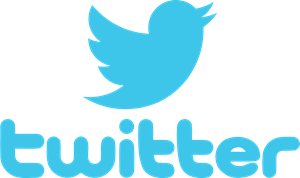

Twitter API allows to fetch live tweets by keyword, or to fetch a 1/6th sample of all twitter traffic.

### Setting up Twitter Credentials

* go to https://apps.twitter.com/
* Apply for a (personal) twitter developer account
* Create a new project
* "Keys and Access Tokens"
* save four keys into `.env` file (or copy `sample.env` to `.env` first)
    * `CONSUMER_KEY` = Consumer Key (API Key)
    * `CONSUMER_SECRET` = Consumer Secret (API Secret)
    * `TWITTER_TOKEN` = Access Token
    * `TWITTER_SECRET` = Access Token Secret

### Getting Started

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
TWITTER_TOKEN = os.environ['TWITTER_TOKEN']
TWITTER_SECRET = os.environ['TWITTER_SECRET']

In [2]:
import re

import twitter

# create new twitter stream
stream = twitter.TwitterStream(
    timeout=3600,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

def get_tweets(terms):
    """
    stream all tweets (within 1/6th quota) indefinitely that contain any of the `terms`.
    
    `statuses.filter` doesn't always return correct matches, so we have to double-check ;)
    """
    # NOTE: using weird syntax instead of '\b' for non-word-boundaries (i.e. starting with '#')
    rex = re.compile(
        r'(?:^|[\W\D]|$)(?:%s)(?:^|[\W\D]|$)' % ('|'.join(re.escape(k) for k in terms),),
        flags=re.I)
    track = ','.join(terms)
    
    for tweet in stream.statuses.filter(track=track):
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        if tweet.get('lang') == 'en' and rex.search(text):
            yield tweet

### Tweet Filtering

We are looking for all current live tweets that contain the following keywords.
Let's see how long it will take to fetch 10 live tweets?

In [3]:
from itertools import islice

from tqdm import tqdm_notebook

terms = [
    '#BigData',
    '#MachineLearning',
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'data science',
    '#ml',
    '#deeplearning',
    '#datascience',
    '#machinelearning',
    'natural language processing'
]

    
res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 10))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

### Tweet Structure

A tweet contains a lot of data and metadata:

In [4]:
import json

print(json.dumps(res[0], indent=4))

{
    "created_at": "Thu Sep 27 14:05:48 +0000 2018",
    "id": 1045313562632228864,
    "id_str": "1045313562632228864",
    "text": "RT @FrontBigData: \"Machine Learning with Radiation Oncology Big Data\", a new Article Collection on groundbreaking science by by our Ed. Boa\u2026",
    "source": "<a href=\"http://www.onmedic.com\" rel=\"nofollow\">bot_eheatlh</a>",
    "truncated": false,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 865488862750965761,
        "id_str": "865488862750965761",
        "name": "ehealth",
        "screen_name": "e_health_",
        "location": null,
        "url": null,
        "description": null,
        "translator_type": "none",
        "protected": false,
        "verified": false,
        "followers_count": 2149,
        "friends_count": 345,
        "listed_count": 39,
        "favourit

### Matched Tweets

Let's look at some of the tweet texts we have captured:

In [5]:
import json
import pandas as pd
pd.options.display.max_colwidth = 280


def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    for tweet in tweets:
        yield {
            'text': tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text'),
            'author': tweet.get('user', {}).get('screen_name'),
            #'lang': tweet.get('lang'),
            # 'urls': [x.get('expanded_url') or x.get('url') for x in tweet.get('entities', {}).get('urls')]
        }

        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

,author,text
0,e_health_,"RT @FrontBigData: ""Machine Learning with Radiation Oncology Big Data"", a new Article Collection on groundbreaking science by by our Ed. Boa…"
1,MuslimHuman3,RT @thedatainc: Foundations of Data Science is our 8 week online course for learning the basics of Data Science. \nThe deadline for this cou…
2,ainwscom,It's time to address artificial intelligence's ethical problems https://t.co/0o3QjqubBh #artificial_intelligence #science https://t.co/z6xL7QVEhR
3,pboardman11,Hands on with Deep Learning and IoT with MATLAB@mathworks@matlab#ghc18#shelovesmatlab https://t.co/693gLmOfGl
4,Robert_M_Barger,"RT @GrowUrStartup: Let #data drive decisions, not the highest paid person's opinion. #Analytics #BigData #Entrepreneur #Startup #DigitalMar…"
5,bitcoinagile,Findera taps a database of 133 million records to connect professionals #BigData #ai #artificialintelligence #category-/Business&amp;amp;Industrial #Findera #machinelearning #searchengine https://t.co/QsVhzblf56 https://t.co/EdSexbbR9R
6,dvet79,RT @stratorob: The latest Robin's #Insurtech Daily! https://t.co/oou5uTQeV5 #AI #Industry40 #BigData #IoT #machinelearning #Cloud #smartho…
7,DarnellCEO,"NVIDIA Brings New Tensor Core GPU AI Tools, Super SloMo, Cutting-Edge \n\n#ai #machinelearning #deeplearning #gpu #supercomputers #quantumcomputing https://t.co/WjrogVp2A8"
8,thomashilbig2,RT @DeepLearn007: How understanding the brain will let us supercharge AI\n#AI #MachineLearning #DeepLearning #BigData #Fintech #Insurtech #M…
9,WebsiteIncrease,I Will Drive Website Traffic to Your Business \n\nSee details -----&gt;&gt; https://t.co/wZf1Fn9sLD \n\n #socialmedia #socialmediamarketing #digitalmarketing #contentmarketing #growthhacking #startup #SEO #SMM #ecommerce #marketing #influencermarketing #blogging #infographic...


### Hashtags

Find which hashtags occur most frequently in our matched tweets

In [6]:
import gzip
import json
from collections import Counter
import pandas as pd


def get_tweets():
    """
    load matched tweets from file
    """
    with gzip.open('data/machine_learning-2018-09-26.jl.gz', 'rt') as fhandle:
        for line in fhandle:
            yield json.loads(line)

            
def hashtags(elt):
    """
    get all hashtags from deep within tweet (extended_tweet, retweets, etc.)
    """
    if isinstance(elt, list):
        for x in elt:
            yield from hashtags(x)
    elif isinstance(elt, dict):
        if 'hashtags' in elt:
            yield [x.get('text').lower() for x in elt['hashtags']]
        for v in elt.values():
            yield from hashtags(v)
            
            
tweets = list(islice(get_tweets(), 1000))
hashtags_per_tweet = [sum(hashtags(tweet), []) for tweet in tweets]
all_hashtags = sum(hashtags_per_tweet, []) 
ctr = Counter(all_hashtags)
pd.DataFrame(ctr.most_common(30))

,0,1
0,ai,771
1,bigdata,555
2,machinelearning,532
3,iot,344
4,datascience,339
5,deeplearning,294
6,ml,198
7,artificialintelligence,169
8,fintech,165
9,blockchain,138


### Leveraging Twitter Data

Based on the Twitter data we can generate many potential use cases:

* [Matched Tweets per Day](https://fluquid.com:5000/twitter)
* [DeepMoji](https://github.com/bfelbo/DeepMoji)
* Find job offerings
* Build a social graph of tweeters
* Engage with trending tweets, conversations in your niche
* Build live language models, sentiment analysis i.e. for elections
* etc.